# CAB420 Linear Regression, Bonus Example: StatsModels vs SKLearn
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

One of the great things about python is that there are lots of ways to do any one thing. At times, this can also be a bit shit, as you may not know quite which approach to take.

For linear regression, there are really two main packages that you will see discussed on the internets:
* StatsModels, which we've used in most of the linear regression examples
* SKLearn, which we're going to start using for classification

Which is better? Well, that kind of comes down to what you want to do. StatsModels is probably richer in terms of giving you lots of the stats goodness that underpins the models (and which we're totally glossing over in CAB420), but SKLearn is a more mature package with the same API for a whole heap of other stuff. For more general ML type stuff, SKLearn is probably better. For more stats heavy stuff, StatsModels is probably better. The reason we've used statsmodels so far is that we do at least have a passing interest in things like p-values, which statsmodels gives us, and sklearn doesn't provide quite as easily (given the ability to misuse p-values, this is perhaps not the worst choice on sklearns part). Really though, the bottom line is you can use either.

This example is simply going to have a look at the two side by side. What you'll see is:
* In terms of use, they are very similar. Fitting models, making predictions, a finding an optimal value of $\lambda$ all look very much the same in both.
* Results from the packages are similar, but not identical. The different results is interesting, but is not actually cause for alarm, as we'll discuss further down.

### How Does this Connect to the Rest of CAB420?

Well, it's still linear regression. It's just another way to do the stuff we've already been doing. As we're going to start using SKLearn a fair bit from here, it seemed worth having this too.

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

## The Data

We're going to use a version of the Brisbane Bluetooth Traffic data from `CAB420_Regression_Example_2_Regularised_Regression.ipynb`. Compared to that example, I'm going to do the following differently:
* Take only the first 2000 samples, just to save runtime;
* Only use 2rd order polynomials, and no categoricals. Again, I'm saving runtime here;
* Standardise data immediately, though here laziness wins and we're going to use the StandardScaler class from sklearn;
* Convert my data to numpy arrays rather than leaving it as pandas dataframes.

In [2]:
# load the data
data = pandas.read_csv('../data/BrisbaneData/Bluetooth_hourly_full.csv')
# select just the first 2000 samples, for the first few columns - note I'm skipping the datetime column here
data_to_use = data.iloc[0:2000,1:10].dropna()
# drop missing values and re-index
data_to_use.reset_index(inplace=True, drop=True)
# pull out X and Y data, and convert to numpy
X = data_to_use.iloc[:, 0:-1].to_numpy()
Y = data_to_use.iloc[:,-1].to_numpy().reshape(-1, 1)

# setup and apply polynomial transform
poly_transform = PolynomialFeatures(2)
X_poly = poly_transform.fit_transform(X)
# drop the constant term - I'm going to standardise my data, so I don't want the constant term
X_poly = X_poly[:, 1:]

# split the data. 70/15/15 split again
num_samples = data_to_use.shape[0]
training_samples = int(num_samples*0.7)
validation_samples = int(num_samples*0.15)
X_train = X_poly[0:training_samples, :]
Y_train = Y[0:training_samples]
X_val = X_poly[training_samples:(training_samples + validation_samples), :]
Y_val = Y[training_samples:(training_samples + validation_samples)]
X_test = X_poly[(training_samples + validation_samples):, :]
Y_test = Y[(training_samples + validation_samples):]

# Use StandardScaler to standardise the data. Fit the scaler to the training data
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(Y_train)

# apply standardisation to all data
X_train_std = scaler_x.transform(X_train)
X_val_std = scaler_x.transform(X_val)
X_test_std = scaler_x.transform(X_test)

#### Weirdness Alert!!

Not the `.transform()`, but rather the `.reshape(-1)`. This probably seems odd, and all it's doing is changing these vectors from being of size (N, 1) to (N, ), where N is the number of samples. Why does this matter?

We'll it shouldn't, but due to the rules aronud broadcasting numpy arrays if these are left as a (N, 1) shaped things we can get some unexpected (and very hard to detect) behaviour when computing RMSE with statsmodels outputs. This doesn't occur when things are left as pandas dataframes.

In [3]:
Y_train_std = scaler_y.transform(Y_train).reshape(-1)
Y_val_std = scaler_y.transform(Y_val).reshape(-1)
Y_test_std = scaler_y.transform(Y_test).reshape(-1)

## Linear Regression

We'll start with linear regression. StatsModels first.

In [4]:
linear_model_sm = sm.OLS(Y_train_std, X_train_std).fit()

Now for SKLearn. The main differences in terms of the API are:
* SKLearn will by default include an intercept (i.e. constant) term. If we don't want one (which we don't because we standardised the data) we need to tell it.
* We provide the data when calling `fit`, rather than when setting up the object

The other differences occur with respect to the output, in particular we don't get the nice printed summary with SKLearn that we do with StatsModels.

In [5]:
# SKLearn Linear Regression
# Create the linear regression object, setting whether we want an intercept or not, and then fit the model
linear_model_sk = LinearRegression(fit_intercept = False).fit(X = X_train_std, y = Y_train_std)

Let's compare the models now. To do this we'll look at:
* The actual learned coefficients
* The $R^2$ for the two models
* Performance on the test set, covering a plot and the RMSEs

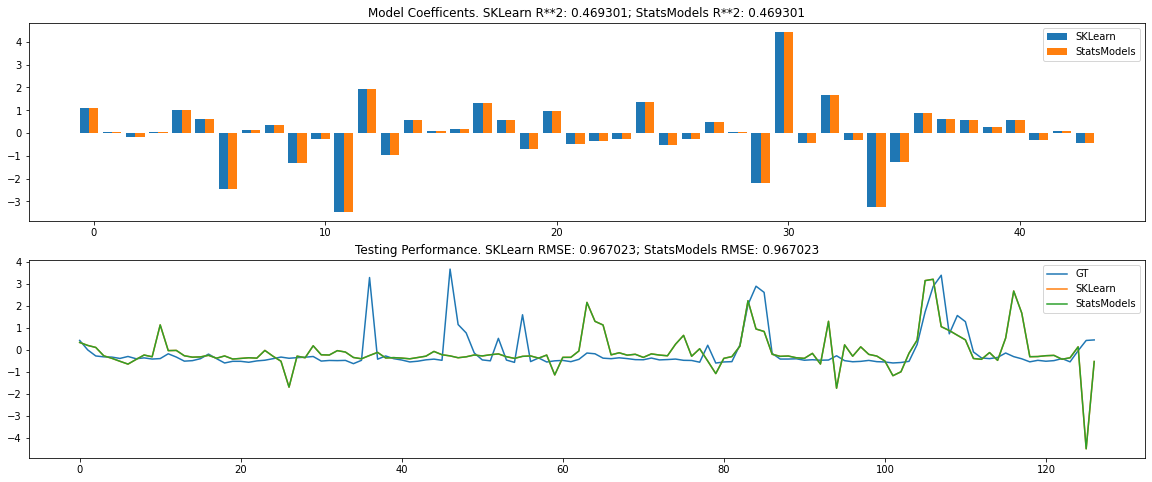

In [6]:
# function to a sklean and statsmodel regression model
def compare_models(sk, sm, X_train, Y_train, X_test, Y_test):

    fig = plt.figure(figsize=[20, 8])
    ax = fig.add_subplot(2, 1, 1)

    # plot coefficients for both models
    w = 0.4
    # sklearn coefficients are found at .coef_
    pos = numpy.arange(0, len(sk.coef_.reshape(-1)), 1)
    ax.bar(pos - w, sk.coef_.reshape(-1), width=w, label='SKLearn')
    # statsmodels coefficients are found at .params
    ax.bar(pos, sm.params, width=w, label='StatsModels')
    # compute R^2 for both models, do this using the sklearn r2_score function
    r_2_sk = r2_score(Y_train, sk.predict(X_train))
    r_2_sm = r2_score(Y_train, sm.predict(X_train))
    ax.set_title('Model Coefficents. SKLearn R**2: %f; StatsModels R**2: %f' % (r_2_sk, r_2_sm))
    ax.legend()

    # plot testing performance for both models
    ax = fig.add_subplot(2, 1, 2)
    ax.plot(Y_test_std, label='GT')
    # both APIs have a predict function, that works in the same way
    ax.plot(sk.predict(X_test), label='SKLearn')
    ax.plot(sm.predict(X_test), label='StatsModels')
    ax.legend()
    # get RMSEs for both models
    rmse_sk = numpy.sqrt(mean_squared_error(Y_test, sk.predict(X_test)))
    rmse_sm = numpy.sqrt(mean_squared_error(Y_test, sm.predict(X_test)))
    ax.set_title('Testing Performance. SKLearn RMSE: %f; StatsModels RMSE: %f' % (rmse_sk, rmse_sm))
    
compare_models(linear_model_sk, linear_model_sm, X_train_std, Y_train_std, X_test_std, Y_test_std)

The models are identical. If you're wondering why in the lower plot you can only see the StatsModels line, it's because that totally overlaps the SKLearn plot. They are identical.

This result is very much unsurprising. There is a closed form solution to linear regression, so we'd expect the exact same result in both cases.

## Ridge Regression

Now for Ridge. We'll start with just a single model from both APIs, with the same value of $\lambda$ for each. 

For SKLearn, we have individual classes for both Ridge and Lasso. Personally, I think this is clearer in terms of implementation, as it's very clear from the code when Ridge or Lasso is being used, whereas with StatsModels you're reliant on inspecting `L1_wt`. The API for Ridge and Lasso is practically identical to SKLearns Linear Regression implementation, with the added requirement of specifying Lambda.

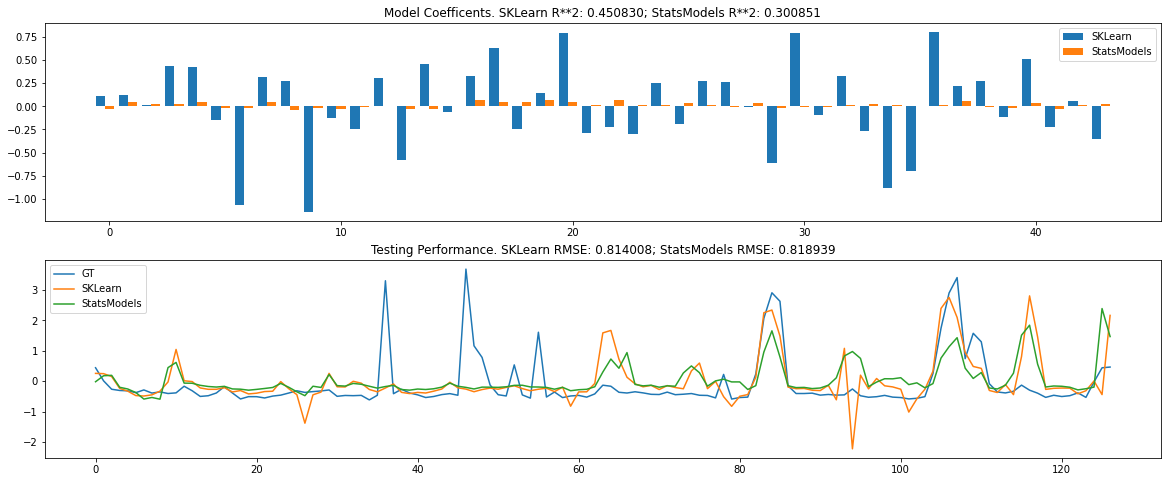

In [7]:
# ridge regression with statsmodels, you've seen this before, the key details are:
#  - use of fit_regularized rather than fit
#  - setting L1_wt = 0.0 such that only the ridge term is active
ridge_model_sm = sm.OLS(Y_train_std, X_train_std).fit_regularized(alpha=1, L1_wt=0.0, profile_scale=False)
# ridge regression with SKLearn. Very similar to the linear model, but now we're using the Ridge object, and need to
# set lambda. Note that with SKLearn, we set lambda when we create the object, rather than when we call fit().
ridge_model_sk = Ridge(fit_intercept = False, alpha=1).fit(X = X_train_std, y = Y_train_std)

# model comparison
compare_models(ridge_model_sk, ridge_model_sm, X_train_std, Y_train_std, X_test_std, Y_test_std)

The results here are probably not what you'd expect. We see that the despite the same value of $\lambda$ being used, we've got far more regularisation being applied by StatsModel. This is simply an implementation variation between the two libraries.

This can be better seen by conducting a search over a range of values.

In [8]:
lambdas = numpy.arange(0, 20, 0.001)

# statsmodels fitting
rmse_train = []
rmse_validation = []
for l in lambdas:
    # iterate over the values of lambda, fitting a model for each
    ridge_model_sm = sm.OLS(Y_train_std, X_train_std).fit_regularized(alpha=l, L1_wt=0.0)
    # compute the RMSE for train and validation
    rmse_train.append(numpy.sqrt(numpy.mean((ridge_model_sm.predict(X_train_std) - Y_train_std)**2)))
    rmse_validation.append(numpy.sqrt(numpy.mean((ridge_model_sm.predict(X_val_std) - Y_val_std)**2)))
     
best_lambda = lambdas[numpy.argmin(rmse_validation)]
print(best_lambda)
ridge_model_sm = sm.OLS(Y_train_std, X_train_std).fit_regularized(alpha=best_lambda, L1_wt=0.0)

# sklearn fitting
rmse_train = []
rmse_validation = []
for l in lambdas:
    # same process as statsmodels, fit the model for the value of lambda
    ridge_model_sk = Ridge(fit_intercept = False, alpha=l).fit(X = X_train_std, y = Y_train_std)
    # comptue the RMSEs. Note that the RMSE computation is identical to statsmodels, we've just changed
    # the name of the model we're calling predict with
    rmse_train.append(numpy.sqrt(numpy.mean((ridge_model_sk.predict(X_train_std) - Y_train_std)**2)))
    rmse_validation.append(numpy.sqrt(numpy.mean((ridge_model_sk.predict(X_val_std) - Y_val_std)**2)))

best_lambda = lambdas[numpy.argmin(rmse_validation)]
print(best_lambda)
ridge_model_sk = Ridge(fit_intercept = False, alpha=best_lambda).fit(X = X_train_std, y = Y_train_std)

0.025
14.66


The optimum value of $\lambda$ we get for both models is very different, yet the actual models that result are almost identical.

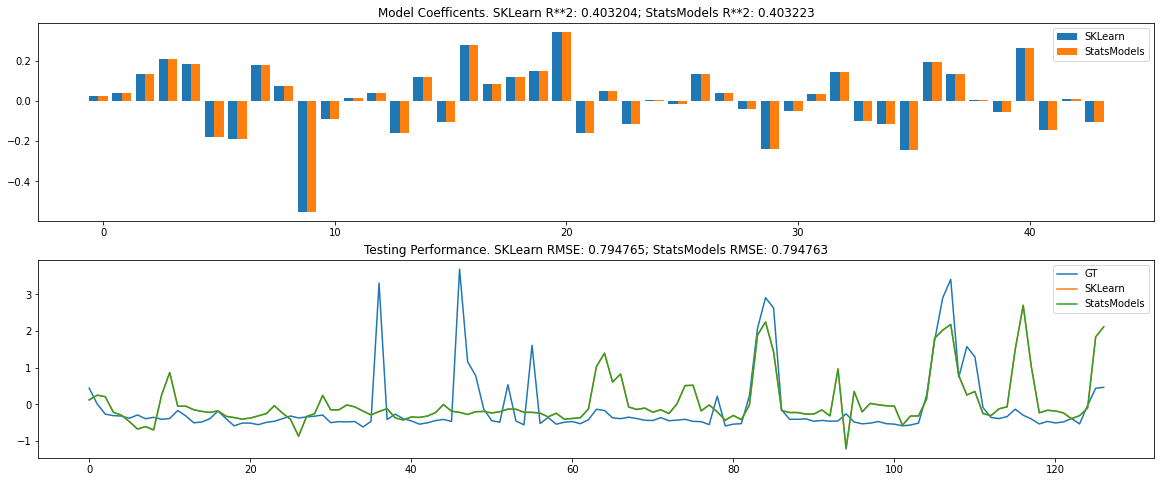

In [9]:
compare_models(ridge_model_sk, ridge_model_sm, X_train_std, Y_train_std, X_test_std, Y_test_std)

This is down to differences in implementation. I can't speak to exactly what these are as I haven't been through the source code, but when comparing implementations in machine learning packages you can reasonably expect differences in details such as:
* The default values of parameters. Even if two implementations have the same parameters, the default values may be different.
* The way an optimistaion process is initialised, and it's convergence conditions.
* The actual optimisation process used.
* The way scaling, or normalisation operations are applied when fitting a model.

These differences will mean that hyper-parameters between packages may change, and you may not be able to completely replicated results acheived in one package with another.

## Lasso  Regression

We'll now try Lasso, once again considering a single value of $\lambda$ for both.

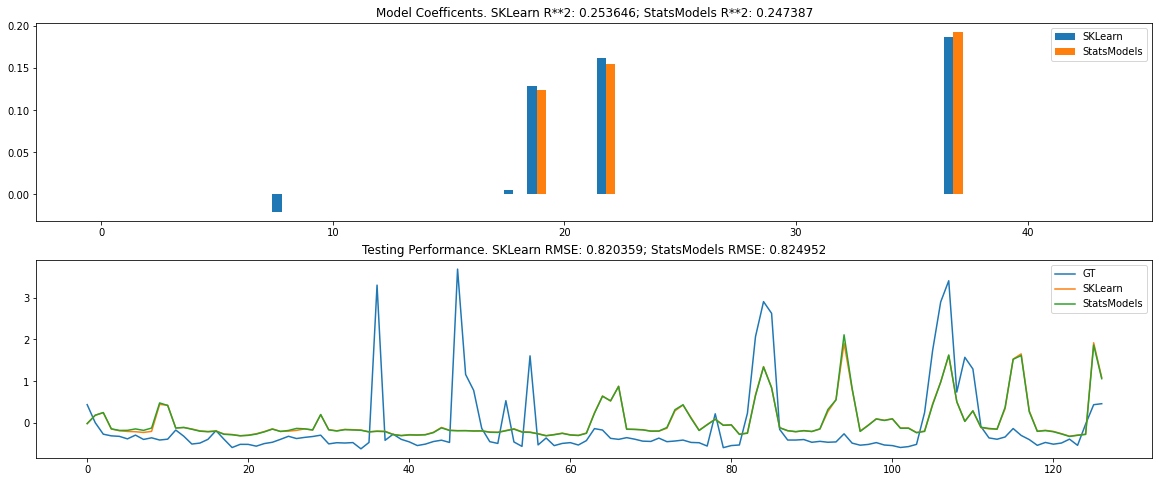

In [10]:
# lasso regression with statsmodels, again this should be familar. Note the
#  - use of fit_regularized rather than fit
#  - setting L1_wt = 1.0 such that only the lasso term is active
lasso_model_sm = sm.OLS(Y_train_std, X_train_std).fit_regularized(alpha=0.1, L1_wt=1.0)
# Lasso with SKLearn. All we've done is change the Ridge object to Lasso, everything else is the same.
lasso_model_sk = Lasso(fit_intercept = False, alpha=0.1).fit(X = X_train_std, y = Y_train_std)

# compare the models
compare_models(lasso_model_sk, lasso_model_sm, X_train_std, Y_train_std, X_test_std, Y_test_std)

In this case, we get similar (though not exact) results. The variations again can be attributed to differences in the implementations.

Considering a range of $\lambda$ values, we see more evidence of these differences.

In [11]:
lambdas = numpy.arange(0.0001, 0.1, 0.0001)
rmse_train = []
rmse_validation = []
for l in lambdas:
    lasso_model_sm = sm.OLS(Y_train_std, X_train_std).fit_regularized(alpha=l, L1_wt=1.0)
    rmse_train.append(numpy.sqrt(numpy.mean((lasso_model_sm.predict(X_train_std) - Y_train_std)**2)))
    rmse_validation.append(numpy.sqrt(numpy.mean((lasso_model_sm.predict(X_val_std) - Y_val_std)**2)))
     
best_lambda = lambdas[numpy.argmin(rmse_validation)]
print(best_lambda)
lasso_model_sm = sm.OLS(Y_train_std, X_train_std).fit_regularized(alpha=best_lambda, L1_wt=1.0)

rmse_train = []
rmse_validation = []
for l in lambdas:
    lasso_model_sk = Lasso(fit_intercept = False, alpha=l, max_iter=50000).fit(X = X_train_std, y = Y_train_std)
    rmse_train.append(numpy.sqrt(numpy.mean((lasso_model_sk.predict(X_train_std) - Y_train_std)**2)))
    rmse_validation.append(numpy.sqrt(numpy.mean((lasso_model_sk.predict(X_val_std) - Y_val_std)**2)))

best_lambda = lambdas[numpy.argmin(rmse_validation)]
print(best_lambda)
lasso_model_sk = Lasso(fit_intercept = False, alpha=best_lambda).fit(X = X_train_std, y = Y_train_std)

0.0092
0.003


/home/simon/venvs/CAB420/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.018e-01, tolerance: 5.860e-02
  model = cd_fast.enet_coordinate_descent(


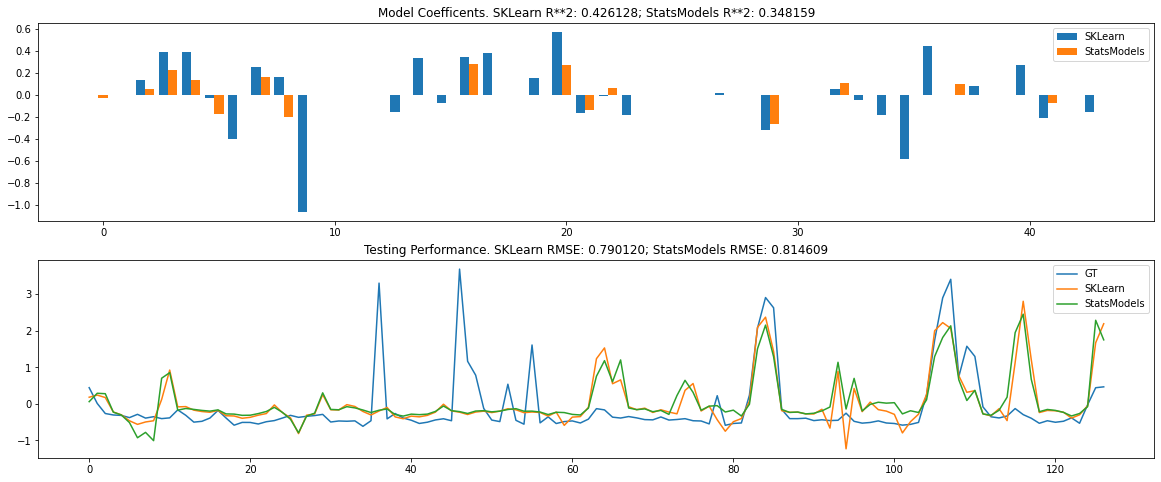

In [12]:
compare_models(lasso_model_sk, lasso_model_sm, X_train_std, Y_train_std, X_test_std, Y_test_std)

We actually get quite different values for $\lambda$ here, and different looking models. The StatsModel output has applied far more regularisation, eliminating more terms. The differences here are likely due to changes in the optimiser and convergence criteria between the packages, leading to StatsModel landing on the more regularised solution.

## StatsModel or SKLearn?

There's no clear winner here, and there's no right choice. While both give different results due to implementation changes, both are performing regularised regression and both are achieving what they set out to do. 

The code that we've written for both are also very similar, particularly when considering only the simple tasks that we've done here. Our computation of RMSEs and of $R^2$s is identical. The process that we're following to select $\lambda$ is identical, with just the changes to the actual call to fit the model needed for the different APIs. 

From a programming standpoint, changing between StatsModels and SKLearn is trivial - but you can expect to see differences in the results (note that how different will also depend on the data). What you should reasonably expect is that:
* Linear regression results should be close to identical, particularly if you have more samples than variables. When you have fewer samples than variables you may see increased variation.
* For regularised regression, you optimal models (i.e. the set of coefficients) should be quite similar (though probably not identical); but the values of $\lambda$ that produce these similar models might be quite different.

I would suggest that for CAB420 at least, you pick the package that suits you best. If you like the statsmodels API and are comfotable with that, keep using that. If you find SKLearn simpler (perhaps you find having explicit Ridge and Lasso) classes makes life easier then use that. Really what I'd avoid at this point is chopping and changing too much between them. Don't fit a Ridge model in one and a Lasso in the other for example. As much as anything, this will just make your code harder to work with and lead to errors on your part.